# Numenta Anomaly Benchmark

### Dataset
* machine_temperature_system_failure.csv
    * Temperature sensor data of an internal component of a large, industrial machine.
    * The first anomaly is a planned shutdown of the machine.
    * The second anomaly is difficult to detect and directly led to the third anomaly, a catastrophic failure of the machine.
    
### Model
* Long Short-Term Memory (LSTM) Autoencoder
    * Long short-term memory (LSTM) is a recurrent neural network (RNN) architecture, used to process entire sequences of data.
    * An autoencoder learns a representation for a set of data in an unsupervised manner by training the network to ignore signal “noise”.
    * The reconstruction error serves as an indicator to the extent of a data instance being an anomaly.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.getcwd(), os.pardir))
from util.utils import *
from model.models import *

Using TensorFlow backend.


,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


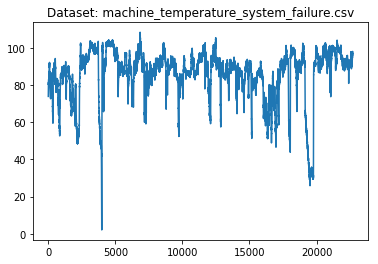

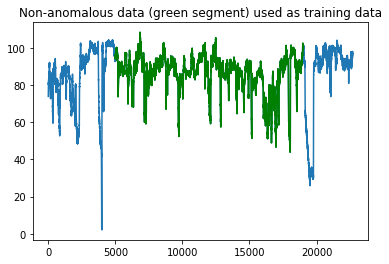

In [10]:
# Import data
df = pd.read_csv("../data/machine_temperature_system_failure.csv")
display(df.head(5))

# Visualise data
plt.title("Dataset: machine_temperature_system_failure.csv")
plt.plot(df['value'])
plt.show()

# Use green area as training data (non-anomalous)
start, end = 5000, 19000
plt.title("Non-anomalous data (green segment) used as training data")
plt.plot(df['value'])
plt.plot(df['value'][start:end], c='g')
plt.show()

In [4]:
# Create a trajectory matrix, i.e. rolling window representation
timeseries_train = df['value'][start:end]
traj_mat_train = get_window(timeseries_train, backward=4)

timeseries_test = df['value']
traj_mat_test = get_window(timeseries_test, backward=4)
traj_mat_train

array([[ 94.97444411,  95.53535487,  95.69837717,  94.75824695,
         95.75646498],
       [ 95.53535487,  95.69837717,  94.75824695,  95.75646498,
         94.35287826],
       [ 95.69837717,  94.75824695,  95.75646498,  94.35287826,
         94.16833924],
       ...,
       [ 99.55650194, 100.0362846 ,  99.42486827,  99.853853  ,
         99.89602116],
       [100.0362846 ,  99.42486827,  99.853853  ,  99.89602116,
         98.43061205],
       [ 99.42486827,  99.853853  ,  99.89602116,  98.43061205,
         99.36111804]])

In [5]:
lae = LSTMAutoEncoder()
lae.fit(traj_mat_train)
scores = lae.predict(traj_mat_test)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 67,205
Trainable params: 67,205
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Train on 11196 samples, validate on 2800 samples
Epoch 1/5
11196/11196 [==============================] - 9s 766us/step - loss: 2984.9398 - mean_absolute_error: 50.7489 - val_loss: 475.1299 - val_mean_absolute_error: 19.2548
Epoch 2/5
11196/11196 [==============================] - 8s 686us/step - loss: 154.0644 - mean_absolute_error: 9.7317 - val_loss: 22.7935 - val_mean_absolute_error: 3.4212
Epoch 3/5
11

In [6]:
ratio = 0.99
sorted_scores = sorted(scores)
threshold = sorted_scores[round(len(scores) * ratio)]

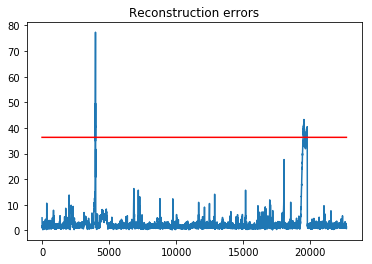

In [7]:
plt.plot(scores)
plt.plot([threshold]*len(scores), c='r')
plt.title("Reconstruction errors")
plt.show()

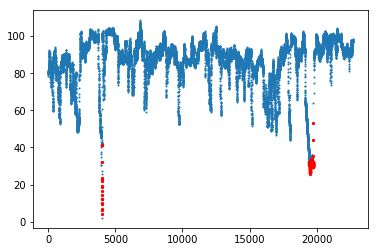

In [8]:
anomaly_idx = np.where(scores > threshold)
normal_idx = np.where(scores <= threshold)

plt.scatter(normal_idx, traj_mat_test[normal_idx][:, -1], s=1)
plt.scatter(anomaly_idx, traj_mat_test[anomaly_idx][:, -1], c='r', s=5)
plt.show()